<a href="https://colab.research.google.com/github/wgova/time_series_trade/blob/master/notebooks/clustering_tsfresh_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [109]:
ref = 0
PATH = '/content/drive/My Drive/Stellenbosch/Webster'
path_to_parameter_eff_features = f'{PATH}/efficient_parameters'
path_to_parameter_comp_features = f'{PATH}/comprehensive_parameters'
list_files_min_feats = os.listdir(path_to_parameter_eff_features)
list_files_eff_features = os.listdir(path_to_parameter_eff_features)
scaled_data_location = f'{PATH}/mean_scaled_products/'
# files = os.listdir(min_feats)
data = list_files_eff_features[ref]
print(data)
product_name = 'engines_misc'

606519_EfficientFCParameters_expval.csv


In [142]:
product_df = pd.read_csv(f'{path_to_parameter_eff_features}/{data}',index_col='id')#,parse_dates=['year'],index_col='year')
product_df_no_nulls = remove_null_values(product_df)

# print(check_outliers(uncorrelated_product_df))
product_df_no_outliers = removing_outliers(product_df_no_nulls)

441

In [143]:
stats_features = ['maximum','mean','skewness','mean_abs_change','mean_change','standard_deviation',
                  'variance','mean_second_derivative_central','median','minimum']

min_feats = ['export_val__kurtosis','export_val__variance','export_val__mean','export_val__skewness',
           'export_val__standard_deviation','export_val__median','export_val__sum_values',
           'export_val__maximum','export_val__length','export_val__minimum']

extra_features = ['fft_coefficient','cwt_coefficients','count','change_quantiles','last_location_',
                 'agg_autocorrelation','index_mass_quantile','sum_values','sum_values','has_duplicate',
                 'length','quantile','ratio_beyond_r_sigma','ratio_value_number_to_time_series_length',
                 'agg','large_standard_deviation','number_crossing_m','number_cwt_peaks','reversal',
                  'value_count','spkt_welch_density','range_count','larger','variation_coefficient',
                 'max_langevin_fixed_point','reoccurring','symmetry_looking','variation','longest_strike_',
                 'variance_larger_than_standard_deviation']

def features_for_exclusion(features_df,features_to_exclude):
  exclude_list = []
  for feat in features_to_exclude:
    feature_cols = features_df.filter(regex=feat,axis=1).columns.to_list()
    exclude_list.extend(feature_cols)
  return exclude_list

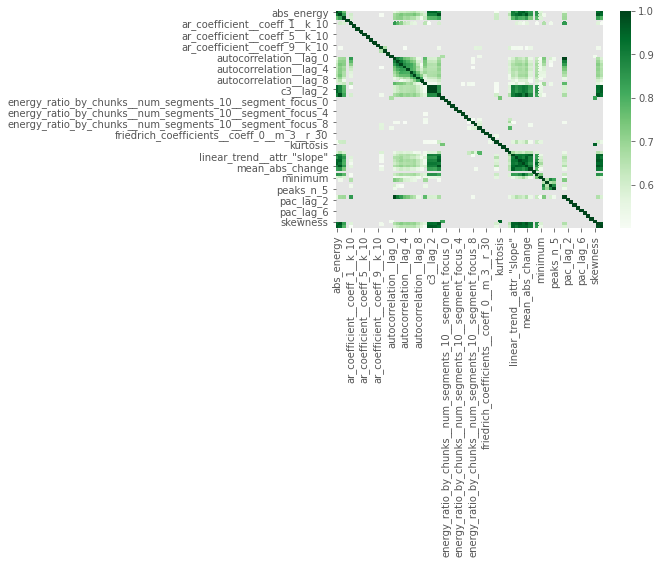

In [145]:
features_exclude_list = features_for_exclusion(product_df_no_outliers,extra_features)
features_filtered_df = product_df_no_outliers[product_df_no_outliers\
                                      .columns[~product_df_no_outliers\
                                               .columns\
                                               .isin(features_exclude_list)]]

features_filtered_df.columns = [re.sub('^export_val__',"", x) for x in features_filtered_df.columns]
features_filtered_df.columns = [re.sub('^augmented_dickey_fuller__attr',"ADF_", x) for x in features_filtered_df.columns]
features_filtered_df.columns = [re.sub('^partial_autocorrelation__',"pac_", x) for x in features_filtered_df.columns]
features_filtered_df.columns = [re.sub('^number_peaks__',"peaks_", x) for x in features_filtered_df.columns]

corr = features_filtered_df.corr()
kot = corr[corr >= .5]
sns.heatmap(kot,cmap="Greens")

31

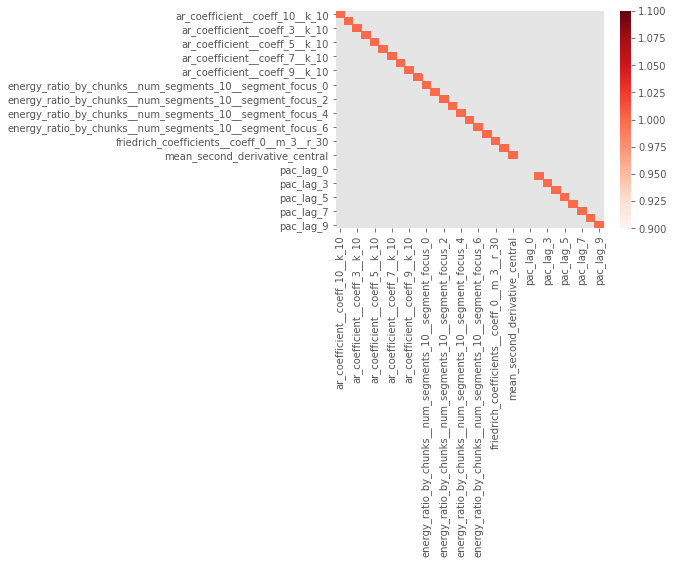

In [140]:
corr = features_filtered_df.corr().abs()
corr_array = corr.unstack()
sorted_corr_array = corr_array.sort_values(kind="quicksort",ascending=False).drop_duplicates()
y = pd.DataFrame(sorted_corr_array).reset_index()
y.rename(columns={"level_0":"feature_1","level_1":"feature_2",0:"score"},inplace=True)
ex = y[y['score']>=0.5]
ex['feature_2'].values

features_uncorrelated = features_filtered_df[features_filtered_df\
                                      .columns[~features_filtered_df\
                                               .columns\
                                               .isin(ex['feature_2'].values)]]
correlated = features_uncorrelated.corr()
red_flags = correlated[correlated >= .49]

sns.heatmap(red_flags,cmap="Reds")
len(features_uncorrelated.columns)

In [146]:
uncorrelated_product_df = features_uncorrelated[features_uncorrelated\
                                      .columns[~features_uncorrelated\
                                               .columns\
                                               .isin(exclude)]]
scaler = StandardScaler()
# scaler.fit_transform(uncorrelated_product_df_no_outliers)
product_scaled_eff_feats = pd.DataFrame(scaler.fit_transform(uncorrelated_product_df),
                              columns = uncorrelated_product_df.columns,
                              index=uncorrelated_product_df.index)
len(product_scaled_eff_feats.columns)

31

## Required packages

In [49]:
!pip install -q oec
import oec
import pandas as pd
import numpy as np
import json
from random import sample
import random
import itertools

import os, os.path, csv, requests, pathlib
from datetime import datetime
import math
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
mpl.style.use('ggplot')

In [50]:
# !pip install -q dtw-python
# dynamic time warping
from dtw import *
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster, ward, dendrogram

from scipy.cluster.vq import kmeans,vq
from math import sqrt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler,normalize
from sklearn.metrics.cluster import homogeneity_score
from sklearn import decomposition
from scipy.stats.mstats import winsorize
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans, SpectralClustering,DBSCAN 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

ModuleNotFoundError: ignored

## Functions for automating clustering

## Data processing

In [136]:
def remove_null_values(df,threshold:int=0.8):
  pct_null = df.isnull().sum() / len(df)
  missing_features = pct_null[pct_null > threshold].index
  df.drop(missing_features, axis=1, inplace=True)
  df.fillna(0,inplace=True)
  return df

def check_outliers(df):
    col = list(df)
    outliers = pd.DataFrame(columns=['columns','Outliers'])
    
    for column in col:
        if column in df.select_dtypes(include=np.number).columns:
            q1 = df[column].quantile(0.25) 
            q3 = df[column].quantile(0.75)
            below = q1 - (1.5*q3 - q1)
            above = q3 + (1.5*q3 - q1)
            outliers = outliers.append({'columns':column,'Outliers':df.loc[(df[column] < below) | (df[column] > above)].shape[0]},ignore_index=True)
    return outliers
    
def removing_outliers(dataframe):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(include=np.number).columns:
            dataframe[col] = winsorize(dataframe[col], limits=[0.1, 0.1],inclusive=(True, True))
    return dataframe

In [51]:
# Functions for dendrograms
# given a linkage model, plog dendogram, with the colors indicated by the a cutoff point at which we define clusters
#https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
def plot_dendrogram(raw_ts_dataframe,name_of_dataset, **kwargs):
    model = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(raw_ts_dataframe.T.values)
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    fig = plt.figure(figsize=(10,5.5))
    fig.suptitle(f'Hierarchical clusters: {name_of_dataset}')
    dendrogram(linkage_matrix, **kwargs)
    plt.savefig(f"hierarchical_{name_of_dataset}")
    return linkage_matrix

# Functions for dtw
def get_dtw_diff_matrix(df,cols:list):
    """
    From a list of series, compute a distance matrix by computing the 
    DTW distance of all pairwise combinations of series.
    """
    diff_matrix = {}
    cross = itertools.product(cols, cols)
    for (col1, col2) in cross:
        series1 = df[col1]
        series2 = df[col2]
        diff = dtw(
            series1, 
            series2,
            keep_internals=True, 
            step_pattern=rabinerJuangStepPattern(2, "c")
            )\
            .normalizedDistance
        diff_matrix[(col1, col2)] = [diff]
    return diff_matrix

def plot_dtw(df,series1:str, series2:str) -> None:
  dtw_df = dtw(df[series1],\
            df[series2],\
            keep_internals=True,
            step_pattern=rabinerJuangStepPattern(2, "c"))
  dtw_df.plot(type="twoway",offset=5)
  plt.savefig(f"DTW_{series1}_{series1}")
  plt.show()

def plot_elbow_silhoutte_k_evaluation(name_of_data: str,data_array,max_clusters):
  range_n_clusters = range(2,max_clusters)
  elbow = []
  s_score = []
  for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters = n_clusters, random_state=42,init='k-means++',max_iter=1000,n_init=1)
    cluster_labels = clusterer.fit_predict(data_array)
    # Average silhouette score
    silhouette_avg = silhouette_score(data_array, cluster_labels)
    s_score.append(silhouette_avg)
    # Average SSE"
    elbow.append(clusterer.inertia_) # Inertia: Sum of distances of samples to their closest cluster center
    
  fig = plt.figure(figsize=(10,5.5))
  fig.suptitle(f"K-means clusters for {name_of_data}", fontsize=16)
  fig.add_subplot(121)
  plt.plot(range_n_clusters, elbow,'b-',label=f'{name_of_data} SSE')
  plt.xlabel("Number of cluster")
  plt.ylabel("Sum of squared error(SSE)")
  plt.legend()
  
  fig.add_subplot(122)
  # plt.title("Covid-19 Rt values silhouette method results")
  plt.plot(range_n_clusters, s_score,'b-',label=f'{name_of_data} \n Silhouette Score')
  plt.xlabel("Number of cluster")
  plt.ylabel("Silhouette Score")
  plt.legend()
  plt.show()

def plot_kmeans_clusters(data_array,number_of_clusters,name_of_data:str):
  # computing K-Means with K = number_of_clusters
  centroids,_ = kmeans(data_array,number_of_clusters)
  # assign each sample to a cluster
  idx,_ = vq(data_array,centroids)
  # some plotting using numpy's logical indexing
  fig, ax = plt.subplots(figsize=(10,5.5))
  fig.suptitle(f"K-means clusters for {name_of_data}", fontsize=12)
  for cluster in range(number_of_clusters):
    colours = ['ob','ok','or','og','om','oc','oy']
    ax.plot(data_array[idx==cluster,0],data_array[idx==cluster,1],colours[cluster],label=f'cluster {cluster}')
    plt.legend()
  plt.savefig(f"{PATH}/images/k_means_{name_of_data}")
  plt.show()
  return idx

## Load data

In [ ]:
yarn_fiber = pd.read_csv(f'{scaled_data_location}/{data}',parse_dates=['year'],index_col='year')
yarn_mean_scaled = remove_null_values(yarn_fiber)

yarn_fiber_min_feats = pd.read_csv(f'{path_to_min_features}/{min_feats[ref]}',index_col='id')
yarn_no_nulls = remove_null_values(yarn_fiber_min_feats)

# Exclude highly correlated features
exclude = [
          #  'export_val__kurtosis',
           'export_val__variance',
          #  'export_val__mean',
           'export_val__skewness',
          #  'export_val__standard_deviation',
          #  'export_val__median',
           'export_val__sum_values','export_val__maximum','export_val__length','export_val__minimum'
           ]

uncorrelated_min_feats_yarn = yarn_no_nulls[yarn_no_nulls\
                                      .columns[~yarn_no_nulls\
                                               .columns\
                                               .isin(exclude)]]
print(check_outliers(uncorrelated_min_feats_yarn))
yarn_fiber_min_feats_no_outliers = removing_outliers(uncorrelated_min_feats_yarn)

ss = StandardScaler()
yarn_clean_scaled_min_feats = pd.DataFrame(ss.fit_transform(yarn_fiber_min_feats_no_outliers),
                              columns = yarn_fiber_min_feats_no_outliers.columns,
                              index=yarn_fiber_min_feats_no_outliers.index)

                          columns Outliers
0            export_val__kurtosis        2
1                export_val__mean       58
2              export_val__median       56
3  export_val__standard_deviation       51


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
#TODO: https://stats.stackexchange.com/questions/427327/simple-outlier-detection-for-time-series
random.seed(20)
random_countries = sample(list(yarn_clean_scaled_min_feats.index),5)
product_excl_countries = yarn_clean_scaled_min_feats[yarn_clean_scaled_min_feats.index.isin(random_countries)]
product_by_countries = yarn_clean_scaled_min_feats[yarn_clean_scaled_min_feats.index.isin(random_countries)]
X_scaled_transposed = np.asarray(yarn_clean_scaled_min_feats)
        # [np.asarray(min_feats_yarn['export_val__minimum']),
        #         np.asarray(min_feats_yarn['export_val__mean']),
        #         # np.asarray(min_feats_yarn['export_val__length']),
        #         # np.asarray(min_feats_yarn['export_val__skewness']),
        #         np.asarray(min_feats_yarn['export_val__kurtosis']),
        #         np.asarray(min_feats_yarn['export_val__median']),
        #         # np.asarray(min_feats_yarn['export_val__mean']),
        #         np.asarray(min_feats_yarn['export_val__standard_deviation']),
        #         # np.asarray(min_feats_yarn['export_val__variance'])
        #         ])).T
X_scaled_transposed.shape

(250, 4)

## EDA and correlation analysis

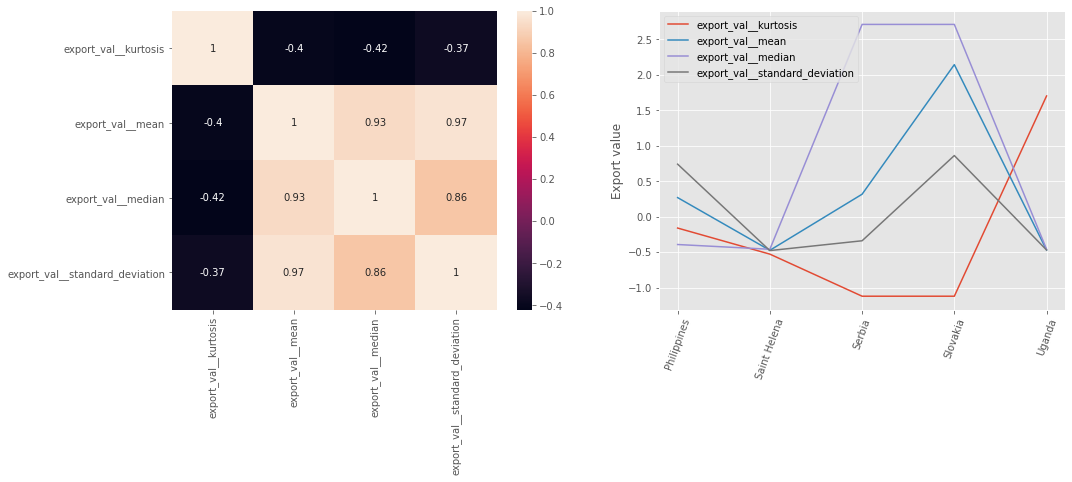

In [ ]:
fig = plt.figure(figsize=(16,5.5))
fig.add_subplot(121)
sns.heatmap(yarn_clean_scaled_min_feats.corr(),annot=True)
# plt.title("Correlation between time series features")
plt.savefig(f"{PATH}/images/correlation_stats_features")

fig.add_subplot(122)
plt.plot(product_excl_countries,label="Here")
# plt.title("Yarn fiber features for randomly picked \n countries excluding outliers")
plt.xticks(rotation=70)
plt.ylabel("Export value")
plt.legend(product_excl_countries.columns)
plt.show()

# Clustering mean scaled time series data

## Hierarchical clustering

<Figure size 720x396 with 0 Axes>

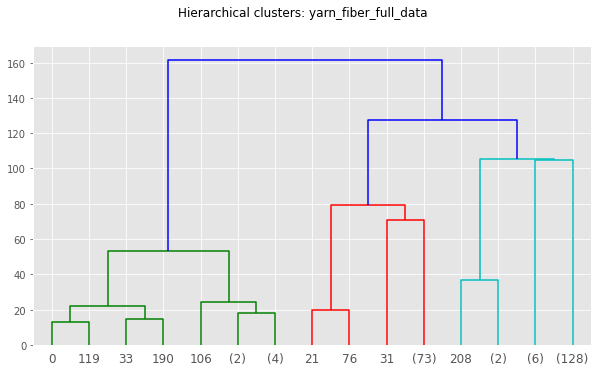

[1 2 6 4 3 5]


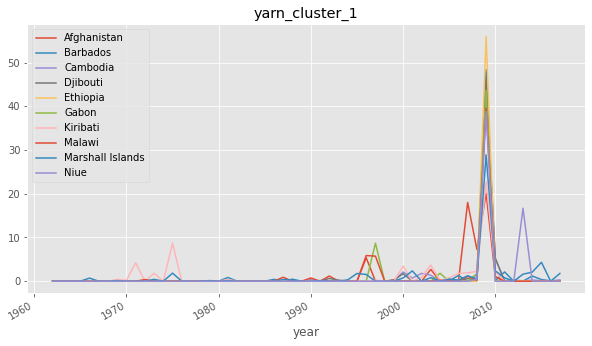

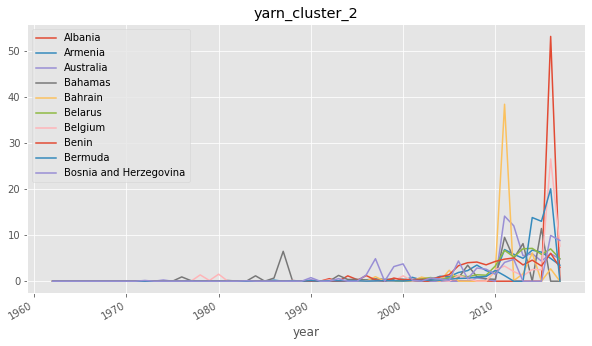

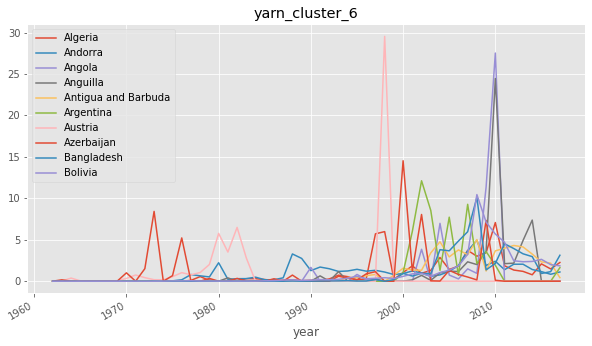

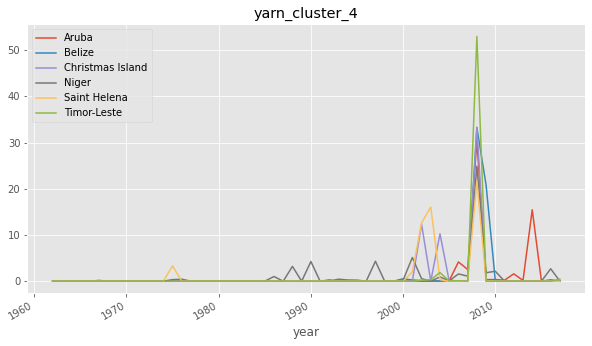

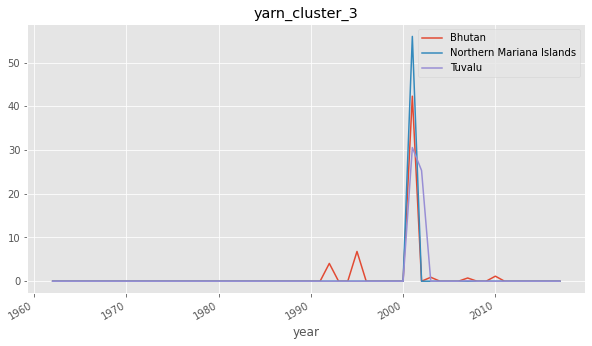

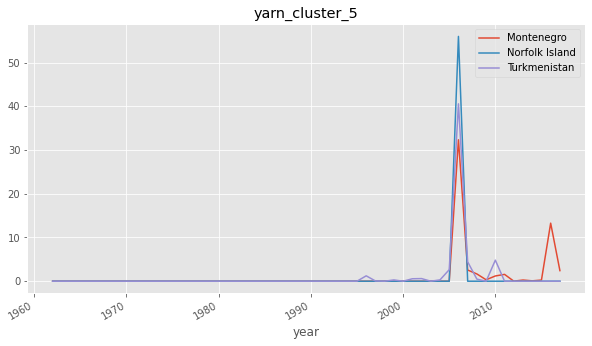

In [ ]:
# plot the top five levels of the dendrogram
plt.figure(figsize = (10,5.5))
linkage_matrix = plot_dendrogram(yarn_mean_scaled, "yarn_fiber_full_data",p=3, color_threshold = 110,truncate_mode='level')
plt.savefig("raw_data_hierarchical")
plt.show()
# extract clusters from dendogram
clusters = fcluster(linkage_matrix, 100, criterion='distance')
# create a lookup table for series in a given cluster
yarn_fiber_clusters = yarn_mean_scaled.T.reset_index()
yarn_fiber_clusters["cluster"] = clusters
yarn_fiber_clusters.rename(columns={'index':'country'},inplace=True)
yarn_fiber_clustered = yarn_fiber_clusters.set_index("cluster country".split())\
    .sort_index()

# cluster analysis
clusters = yarn_fiber_clusters.cluster.unique()
print(clusters)
for c in clusters:
  countries= yarn_fiber_clustered.loc[c].index.get_level_values(0).unique()
  # random.seed(1)
  n_samples = yarn_fiber_clustered.loc[c].shape[0]
  if n_samples > 10:
    n = random.sample(range(n_samples),10)
  else:
    n = range(n_samples)
  cluster = yarn_fiber_clustered.loc[c].T
  cluster.iloc[:, n].plot(subplots=False,figsize = (10,5.5),title=f"yarn_cluster_{c}")
  plt.legend(countries)
  plt.savefig(f"{PATH}/images/yarn_full_ts_cluster{c}")
  plt.show()

## Dynamic time warping

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1450: UserWarning: Use the colorbar set_ticks() method instead.
  ax.set_yticks(self.tick_pos)


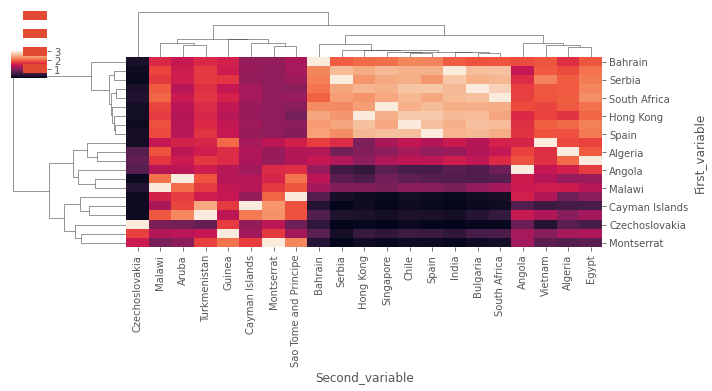

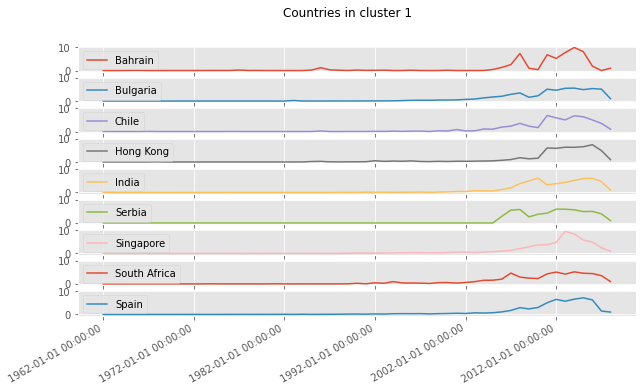

<Figure size 720x396 with 0 Axes>

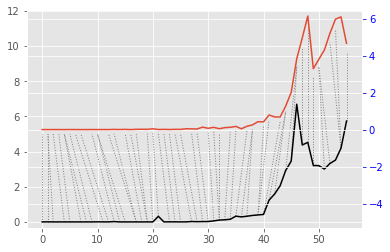

<Figure size 432x288 with 0 Axes>

DTW for Rwanda and Montenegro


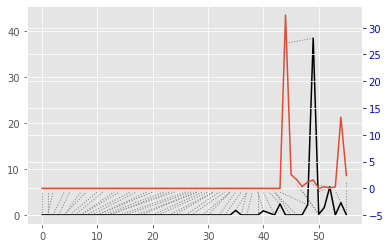

<Figure size 432x288 with 0 Axes>

DTW for Niger and Republic of the Congo


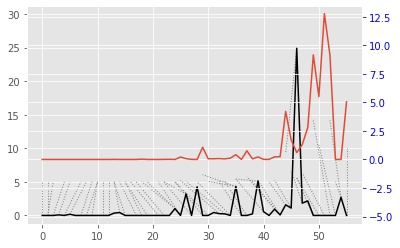

<Figure size 432x288 with 0 Axes>

In [ ]:
# sample 50 series, and compute the DTW distance matrix
random.seed(15)
sample_cols = random.sample(list(yarn_mean_scaled.columns), 20)
sample_cols.append('South Africa')
# sample_cols.extend(['South)
dtw_diff_dict = get_dtw_diff_matrix(yarn_mean_scaled,sample_cols)

# make into a df
dtw_diff_df = pd.DataFrame(dtw_diff_dict).T.reset_index()\
    .rename(columns = {"level_0":"First_variable", "level_1":"Second_variable", 0:"diff"})\
    .pivot_table(index = "First_variable", columns = "Second_variable", values = "diff")

# plot a similarity matrix, with a dendogram imposed
sns.clustermap(1-dtw_diff_df,figsize=(10,5.5))

# ward clustering from difference matrix, where distance is Dynamic time warping distance instead of Euclidean
time_warp = ward(dtw_diff_df)
# extract clusters
dtw_clusters = pd.DataFrame({"cluster":fcluster(time_warp, 1.15)}, index = dtw_diff_df.index)
dtw_clusters.cluster.value_counts().sort_index().plot.barh()
plt.title=("Frequency of DTW clusters")

# Check time series for any cluster
# TODO: Function to loop through all clusters and plot
# What cluster is South Africa? 
#print(dtw_clusters[dtw_clusters.index=='South Africa'])
cluster = 1
yarn_hc_clusters = yarn_mean_scaled.T.merge(
    dtw_clusters.loc[dtw_clusters.cluster ==cluster], 
    left_index = True,
    right_index = True)\
    .T
yarn_hc_clusters.plot(subplots=True,figsize = (10,5.5),sharey=True,title=f'Countries in cluster {cluster}')
plt.show()

fig = plt.figure(figsize=(10,5.5))
fig.suptitle(f'DTW : Examples')
# print('DTW for Turkey and India')
plot_dtw(yarn_mean_scaled,"Turkey", "India")
print('DTW for Rwanda and Montenegro')
plot_dtw(yarn_mean_scaled,"Rwanda", "Montenegro")
# fig.add_subplot(133)
print('DTW for Niger and Republic of the Congo')
plot_dtw(yarn_mean_scaled,"Niger", "Republic of the Congo")

# Clustering TSFRESH extracted features

## Hierarchical clustering TS features

<Figure size 1008x432 with 0 Axes>

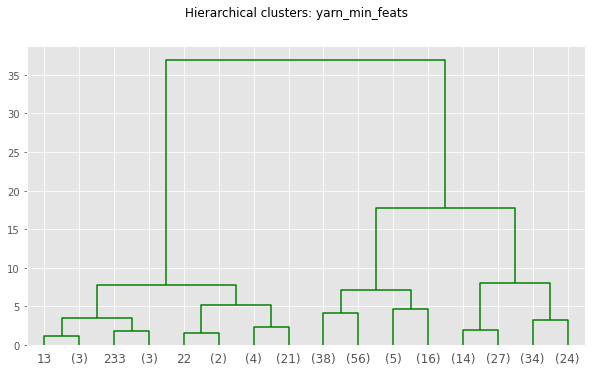

Unique clusters: [1]


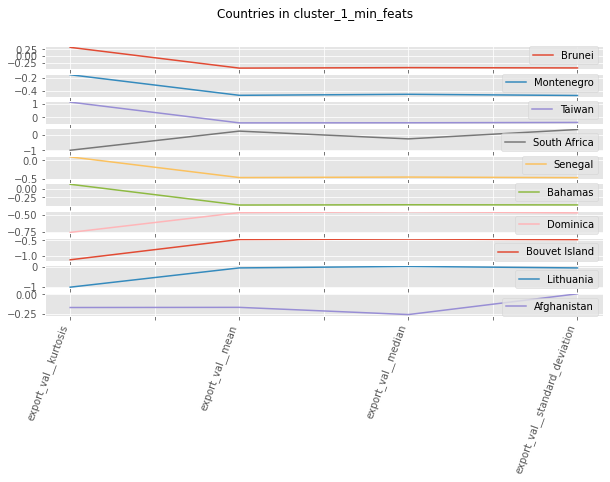

In [ ]:
# feats_clf = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(min_feats_yarn.values)

plt.figure(figsize = (14,6))
# plot the top five levels of the dendrogram
linkage_matrix = plot_dendrogram(yarn_clean_scaled_min_feats.T,"yarn_min_feats", p=3,color_threshold = 110,truncate_mode='level')
plt.show()

# # extract clusters from dendogram
clusters = fcluster(linkage_matrix, 100, criterion='distance')
# # create a lookup table for series in a given cluster
yarn_fiber_clusters = yarn_clean_scaled_min_feats.reset_index()
yarn_fiber_clusters["cluster"] = clusters
clusts = np.unique(clusters)
print(f'Unique clusters: {clusts}')
yarn_fiber_clusters.rename(columns={'id':'country'},inplace=True)
yarn_fiber_clustered = yarn_fiber_clusters.set_index("cluster country".split())\
.sort_index()


# cluster analysis
feats_clusters = yarn_fiber_clusters.cluster.unique()
for c in feats_clusters:
  countries= yarn_fiber_clustered.loc[c].index.get_level_values(0).unique()
  random.seed(1)
  n_samples = yarn_fiber_clustered.loc[c].shape[0]
  if n_samples > 10:
    n = random.sample(range(n_samples),10)
  else:
    n = range(n_samples)
  cluster = yarn_fiber_clustered.loc[c].T
  cluster.iloc[:, n].plot(subplots=True,figsize=(10,5.5),
                          title=f"Countries in cluster_{c}_min_feats")
  plt.xticks(rotation=70)
  plt.legend(countries)
  plt.savefig(f"{PATH}/images/cluster_{c}_min_feats")
  plt.show()

## K-means clustering

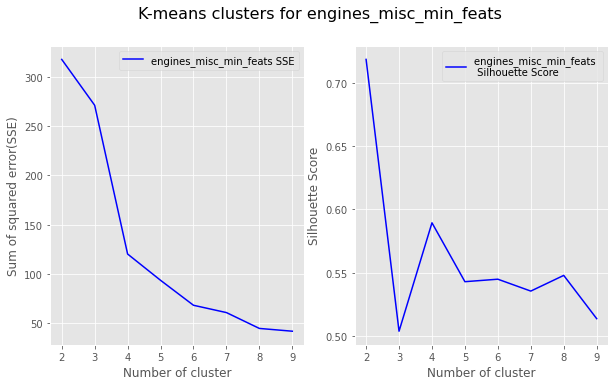

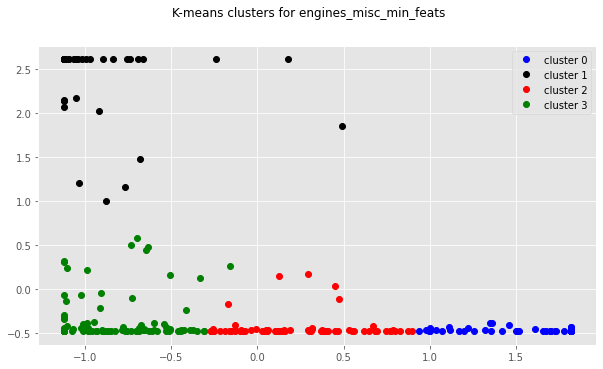

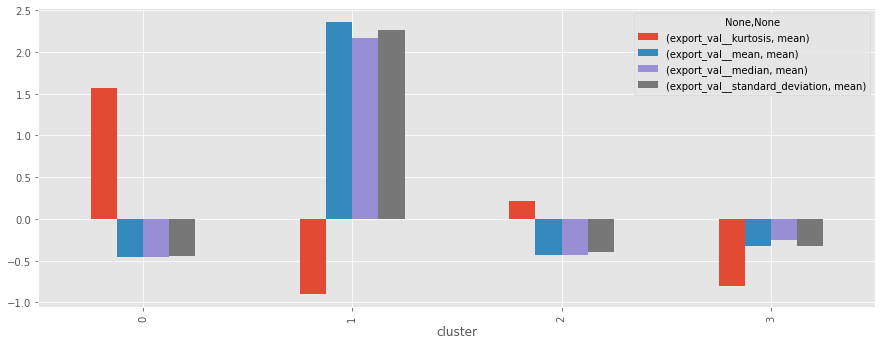

In [ ]:
plot_elbow_silhoutte_k_evaluation(f"{product_name}_min_feats",yarn_clean_scaled_min_feats,10)  
clusters_yarn_min_feats = plot_kmeans_clusters(X_scaled_transposed,4,f"{product_name}_min_feats") #TODO: seperate def get_clusters() \\ plot_kmeans_clusters()

#TODO: function for getting names from cluster
# def get_cluster_elements()
details = [(name,cluster) for name, cluster in zip(yarn_clean_scaled_min_feats.index,clusters_yarn_min_feats)]
cluster_df = pd.DataFrame(details,columns=['names','cluster'])
cluster_df['names'].astype('category')
get_names = yarn_clean_scaled_min_feats.reset_index().rename(columns={'id':'names'})
get_names.names.astype('category')
country_cluster = pd.merge(get_names,cluster_df,how='inner', on='names')
metrics = ['mean']
groups = country_cluster.groupby(['cluster']).agg(metrics)
ax = groups.plot(figsize=(15,5.5),kind='bar')
fig = ax.get_figure()
fig.savefig(f"{product_name}_min_features_kmeans")
# country_cluster[country_cluster.cluster==1]['names'].unique()

## PCA + k-Means

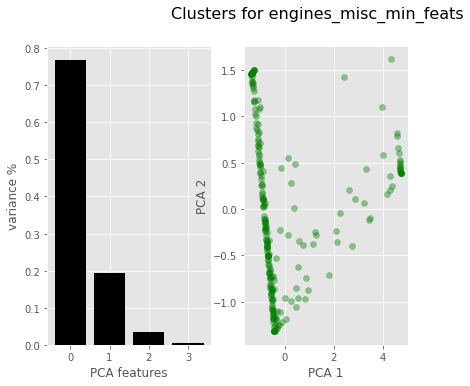

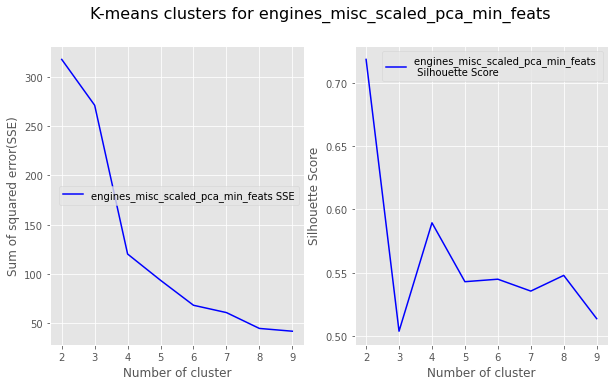

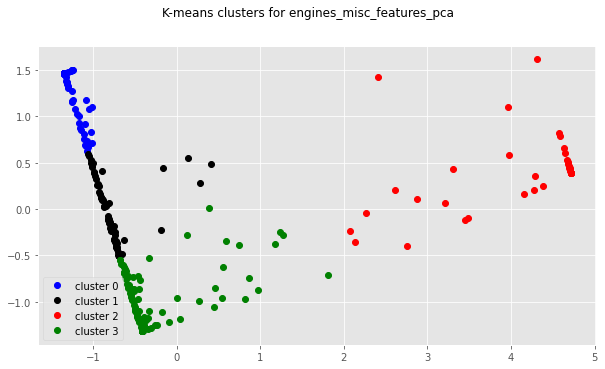

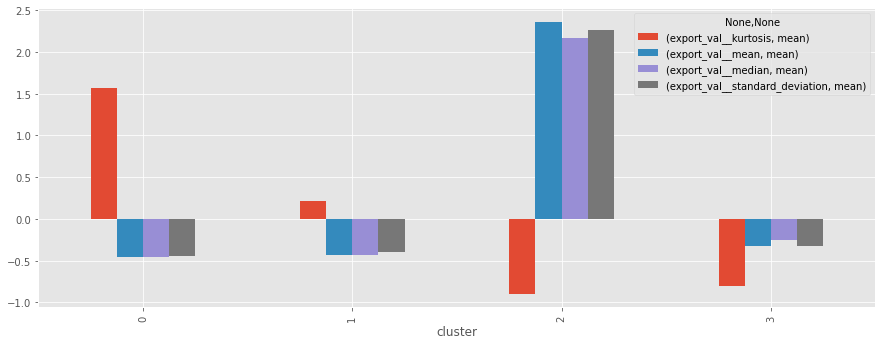

In [ ]:
# Standardize the data to have a mean of ~0 and a variance of 1

# TODO: PCA plots and evaluation
# Create a PCA instance: pca
# def calculate_pca():
  # return pca_components_df

pca = PCA(n_components=4)
principalComponents = pca.fit_transform(yarn_clean_scaled_min_feats)

# def plot_pca_eveluation():
# Plot the explained variances
features = range(pca.n_components_)

fig = plt.figure(figsize=(10,5.5))
fig.suptitle(f"Clusters for {product_name}_min_feats", fontsize=16)
fig.add_subplot(131)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)
fig.add_subplot(132)
plt.scatter(PCA_components[0], PCA_components[1], alpha=.4, color='green')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')


plot_elbow_silhoutte_k_evaluation(f"{product_name}_scaled_pca_min_feats",np.asarray(PCA_components),10)  
clusters_yarn_min_feats = plot_kmeans_clusters(np.asarray(PCA_components),4,f"{product_name}_features_pca")

details = [(name,cluster) for name, cluster in zip(yarn_clean_scaled_min_feats.index,clusters_yarn_min_feats)]
cluster_df = pd.DataFrame(details,columns=['names','cluster'])
cluster_df['names'].astype('category')
get_names = yarn_clean_scaled_min_feats.reset_index().rename(columns={'id':'names'})
get_names.names.astype('category')
country_cluster = pd.merge(get_names,cluster_df,how='inner', on='names')
metrics = ['mean']
groups = country_cluster.groupby(['cluster']).agg(metrics)

ax = groups.plot(figsize=(15,5.5),kind='bar')
fig = ax.get_figure()
fig.savefig(f"{product_name}_min_features_pca_kmeans.png")

## DBSCAN

### Hyperparameter tuning

  0%|          | 1/245 [00:00<00:26,  9.12it/s]

[dbscan] >Normalize data (unit variance, zero-mean).
[dbscan] Gridsearch on epsilon to determine optimal clusters using silhouette scores.


100%|██████████| 245/245 [00:26<00:00,  9.16it/s]

[clusteval] >Fin.


<Figure size 720x396 with 0 Axes>

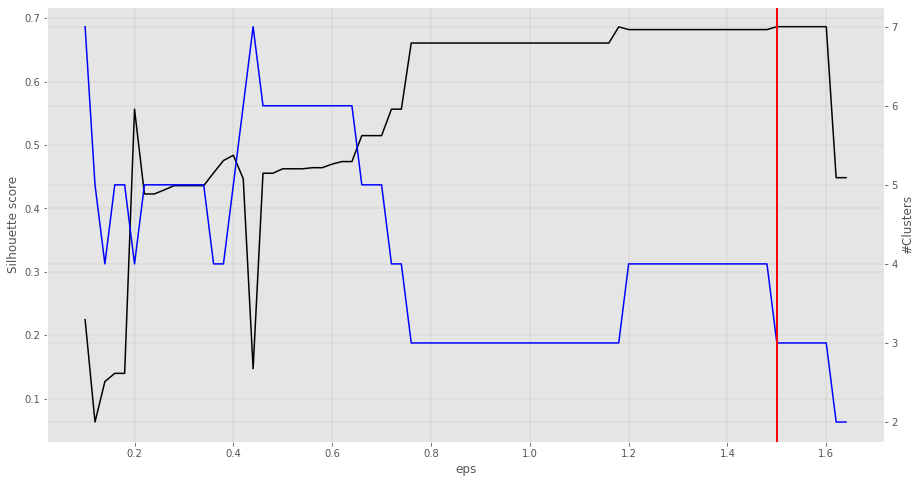

[silhouette] >Estimated number of n_clusters: 3, average silhouette_score=0.686


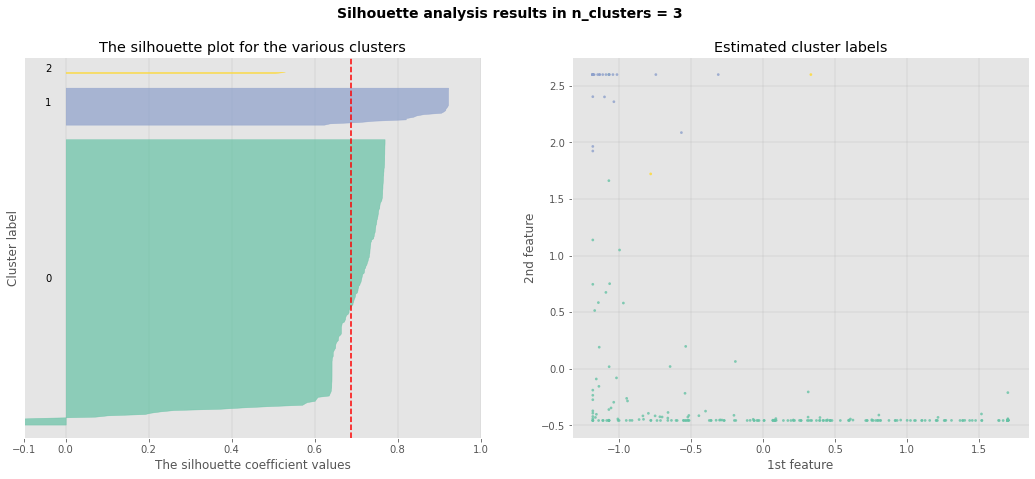

In [ ]:
# https://stackoverflow.com/questions/34611038/grid-search-for-hyperparameter-evaluation-of-clustering-in-scikit-learn
!pip install -q clusteval
# Import library
from clusteval import clusteval
# Set parameters, as an example dbscan
ce = clusteval(method='dbscan')
# Fit to find optimal number of clusters using dbscan
results= ce.fit(X_scaled_transposed)
# Make plot of the cluster evaluation
plt.figure(figsize=(10,5.5))
ce.plot()
# Make scatter plot. Note that the first two coordinates are used for plotting.
ce.scatter(X_scaled_transposed)
# results is a dict with various output statistics. One of them are the labels.
cluster_labels = results['labx']

### DBSCAN clustering

In [ ]:
# https://www.dummies.com/programming/big-data/data-science/how-to-create-an-unsupervised-learning-model-with-dbscan/
dbscan = DBSCAN(eps=0.5, min_samples=5,metric='euclidean')
dbscan_results_yarn = dbscan.fit(X_scaled_transposed)
print(np.unique(dbscan.labels_))

[-1  0  1]


[-1  0  1]


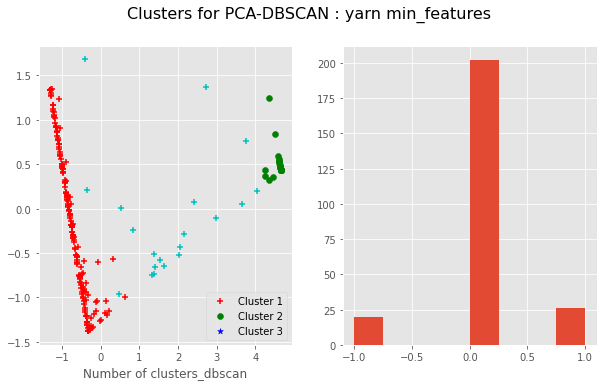

In [ ]:
# https://www.dummies.com/programming/big-data/data-science/how-to-create-an-unsupervised-learning-model-with-dbscan/
dbscan = DBSCAN(eps=0.5, min_samples=5,metric='euclidean')
dbscan.fit(X_scaled_transposed)
fig = plt.figure(figsize=(10,5.5))
fig.suptitle("Clusters for PCA-DBSCAN : yarn min_features", fontsize=16)
print(np.unique(dbscan.labels_))
fig.add_subplot(121)
# fig.set_title('Clusters')
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X_scaled_transposed)
for i in range(0, pca_2d.shape[0]):
  if dbscan.labels_[i] == 0:
    c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
  elif dbscan.labels_[i] == 1:
    c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='o')
  elif dbscan.labels_[i] == 2:
    c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='*')
  elif dbscan.labels_[i] == 3:
    c4 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='y',marker='x')
  elif dbscan.labels_[i] == 4:
    c5 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='*')
  elif dbscan.labels_[i] == 5:
    c6 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='x')
  elif dbscan.labels_[i] == -1:
    c7 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='c',marker='+')
plt.xlabel("Number of clusters_dbscan")
plt.legend([c1, c2, c3], ['Cluster 1', 
                                'Cluster 2',
                                'Cluster 3',
                                'Cluster 4',
                                'Cluster 5',
                                'Cluster 6',
                                'Noise'])

# plt.title('DBSCAN finds 2 clusters and noise')
fig.add_subplot(122)
# plt.set_title=("Cluster instances/frequency")
plt.hist(dbscan.labels_,bins=8)
plt.savefig(f"{PATH}/images/yarn_min_feats_pca_dbscan")
plt.show()